In [2]:
# import packages
import os, gc
import zarr
import numpy as np 
import pandas as pd 
from tqdm import tqdm
from typing import Dict
from collections import Counter
from prettytable import PrettyTable

#level5 toolkit
from l5kit.data import PERCEPTION_LABELS
from l5kit.dataset import EgoDataset, AgentDataset
from l5kit.data import ChunkedDataset, LocalDataManager

# level5 toolkit 
from l5kit.configs import load_config_data
from l5kit.geometry import transform_points
from l5kit.rasterization import build_rasterizer
from l5kit.visualization import draw_trajectory, draw_reference_trajectory, TARGET_POINTS_COLOR
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation

# deep learning
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet18, resnet50, resnet34

# check files in directory
print((os.listdir('data/')))

plt.rc('animation', html='jshtml')

%matplotlib inline

['aerial_map', 'scenes', 'semantic_map', 'meta.json', 'visualisation_config.yaml', 'multi_mode_sample_submission.csv', 'single_mode_sample_submission.csv', 'agent_motion_config.yaml']


In [3]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "data/"

cfg = load_config_data('data/visualisation_config.yaml')

In [4]:
print(f'current raster_param:\n')
for k,v in cfg["raster_params"].items():
    print(f"{k}:{v}")

current raster_param:

raster_size:[224, 224]
pixel_size:[0.5, 0.5]
ego_center:[0.25, 0.5]
map_type:py_semantic
satellite_map_key:aerial_map/aerial_map.png
semantic_map_key:semantic_map/semantic_map.pb
dataset_meta_key:meta.json
filter_agents_threshold:0.5


In [5]:
train = zarr.open("data/scenes/train.zarr")
validation = zarr.open("data/scenes/validate.zarr")
test = zarr.open("data/scenes/test.zarr/")
train.info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.DirectoryStore
No. members,5
No. arrays,4
No. groups,1
Arrays,"agents, frames, scenes, traffic_light_faces"
Groups,agents_mask


In [6]:
print(f'We have {len(train.agents)} agents, {len(train.scenes)} scenes, {len(train.frames)} frames and {len(train.traffic_light_faces)} traffic light faces in train.zarr.')
print(f'We have {len(validation.agents)} agents, {len(validation.scenes)} scenes, {len(validation.frames)} frames and {len(validation.traffic_light_faces)} traffic light faces in validation.zarr.')
print(f'We have {len(test.agents)} agents, {len(test.scenes)} scenes, {len(test.frames)} frames and {len(test.traffic_light_faces)} traffic light faces in test.zarr.')


We have 320124624 agents, 16265 scenes, 4039527 frames and 38735988 traffic light faces in train.zarr.
We have 312617887 agents, 16220 scenes, 4030296 frames and 29277930 traffic light faces in validation.zarr.
We have 88594921 agents, 11314 scenes, 1131400 frames and 7854144 traffic light faces in test.zarr.


In [7]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "data"

# get configuration yaml
cfg = load_config_data("data/visualisation_config.yaml")
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'history_step_size': 1, 'history_delta_time': 0.1, 'future_num_frames': 50, 'future_step_size': 1, 'future_delta_time': 0.1}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5}, 'val_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}}


In [17]:
# Raster Parameters
print(f'current raster_param:\n')
for k,v in cfg["raster_params"].items():
    print(f"{k}:{v}")

current raster_param:

raster_size:[224, 224]
pixel_size:[0.5, 0.5]
ego_center:[0.25, 0.5]
map_type:py_semantic
satellite_map_key:aerial_map/aerial_map.png
semantic_map_key:semantic_map/semantic_map.pb
dataset_meta_key:meta.json
filter_agents_threshold:0.5


In [8]:
dm = LocalDataManager()
dataset_path = dm.require('scenes/sample.zarr')
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

+------------+------------+------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [9]:
print(dataset_path)

data/scenes/sample.zarr


In [10]:
zarr_dataset.agents

<zarr.core.Array '/agents' (1893736,) [('centroid', '<f8', (2,)), ('extent', '<f4', (3,)), ('yaw', '<f4'), ('velocity', '<f4', (2,)), ('track_id', '<u8'), ('label_probabilities', '<f4', (17,))] read-only>

In [11]:
agents = pd.DataFrame.from_records(zarr_dataset.agents, columns = ['centroid', 'extent', 'yaw', 'velocity', 'track_id', 'label_probabilities'])
agents.head()

,centroid,extent,yaw,velocity,track_id,label_probabilities
0,"[665.0342407226562, -2207.51220703125]","[4.3913283, 1.8138304, 1.5909758]",1.016675,"[0.0, 0.0]",1,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[717.6612548828125, -2173.760009765625]","[5.150925, 1.9530917, 2.04021]",-0.783224,"[0.0, 0.0]",2,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[730.681396484375, -2180.678955078125]","[2.9482825, 1.4842174, 1.1125067]",-0.321747,"[0.0, 0.0]",3,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[671.2536010742188, -2204.745361328125]","[1.7067024, 0.9287868, 0.6282158]",0.785501,"[0.0, 0.0]",4,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[669.7763061523438, -2213.004638671875]","[0.25109944, 0.6343781, 1.654377]",1.492359,"[0.0, 0.0]",5,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [12]:
np.array(agents['centroid'].to_list())[:,0]

array([665.03424072, 717.66125488, 730.68139648, ..., 227.16343689,
       213.86314392, 293.89666748])

In [13]:
agents['centroid_x'] = np.array(agents['centroid'].to_list())[:,0]

In [14]:
agents['centroid_x'] = np.array(agents['centroid'].to_list())[:,0]
agents['centroid_y'] = np.array(agents['centroid'].to_list())[:,1]
agents = agents.drop('centroid', axis=1)
agents_new = agents[["centroid_x", "centroid_y", "extent", "yaw", "velocity", "track_id", "label_probabilities"]]
del agents
agents_new

,centroid_x,centroid_y,extent,yaw,velocity,track_id,label_probabilities
0,665.034241,-2207.512207,"[4.3913283, 1.8138304, 1.5909758]",1.016675,"[0.0, 0.0]",1,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,717.661255,-2173.760010,"[5.150925, 1.9530917, 2.04021]",-0.783224,"[0.0, 0.0]",2,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,730.681396,-2180.678955,"[2.9482825, 1.4842174, 1.1125067]",-0.321747,"[0.0, 0.0]",3,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,671.253601,-2204.745361,"[1.7067024, 0.9287868, 0.6282158]",0.785501,"[0.0, 0.0]",4,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,669.776306,-2213.004639,"[0.25109944, 0.6343781, 1.654377]",1.492359,"[0.0, 0.0]",5,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...
1893731,278.237427,50.953831,"[2.651326, 16.242971, 1.8459053]",0.728024,"[0.0, 0.0]",1478,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1893732,321.081635,35.298061,"[0.34564313, 0.7559242, 0.5863746]",0.582523,"[0.09659984, -0.23340665]",1479,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1893733,227.163437,73.988060,"[2.024245, 0.3544109, 0.8435698]",0.942606,"[-0.091657355, 3.9186544]",1481,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1893734,213.863144,75.332466,"[0.51277804, 1.2809446, 1.1334285]",-0.809572,"[0.0, 0.0]",1483,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


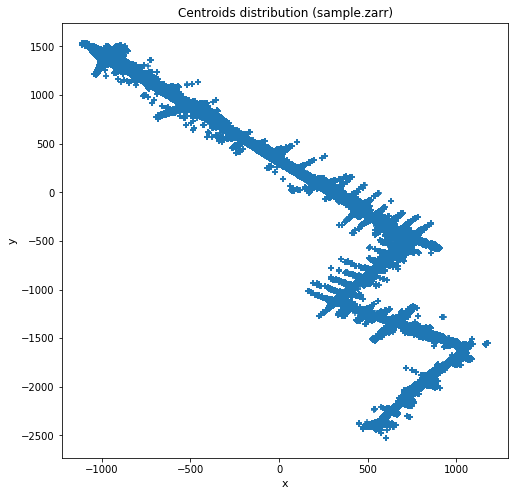

In [15]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
plt.scatter(agents_new['centroid_x'], agents_new['centroid_y'], marker='+')
plt.xlabel('x', fontsize=11); plt.ylabel('y', fontsize=11)
plt.title("Centroids distribution (sample.zarr)")
plt.show()

In [16]:
agents_new['extent_x'] = np.array(agents_new['extent'].to_list())[:,0]
agents_new['extent_y'] = np.array(agents_new['extent'].to_list())[:,1]
agents_new['extent_z'] = np.array(agents_new['extent'].to_list())[:,2]
agents_new = agents_new.drop('extent', axis=1)
agents = agents_new[["centroid_x", "centroid_y", 'extent_x', 'extent_y', 'extent_z', "yaw", "velocity", "track_id", "label_probabilities"]]
del agents_new
agents

,centroid_x,centroid_y,extent_x,extent_y,extent_z,yaw,velocity,track_id,label_probabilities
0,665.034241,-2207.512207,4.391328,1.813830,1.590976,1.016675,"[0.0, 0.0]",1,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,717.661255,-2173.760010,5.150925,1.953092,2.040210,-0.783224,"[0.0, 0.0]",2,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,730.681396,-2180.678955,2.948282,1.484217,1.112507,-0.321747,"[0.0, 0.0]",3,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,671.253601,-2204.745361,1.706702,0.928787,0.628216,0.785501,"[0.0, 0.0]",4,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,669.776306,-2213.004639,0.251099,0.634378,1.654377,1.492359,"[0.0, 0.0]",5,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...
1893731,278.237427,50.953831,2.651326,16.242971,1.845905,0.728024,"[0.0, 0.0]",1478,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1893732,321.081635,35.298061,0.345643,0.755924,0.586375,0.582523,"[0.09659984, -0.23340665]",1479,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1893733,227.163437,73.988060,2.024245,0.354411,0.843570,0.942606,"[-0.091657355, 3.9186544]",1481,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1893734,213.863144,75.332466,0.512778,1.280945,1.133428,-0.809572,"[0.0, 0.0]",1483,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


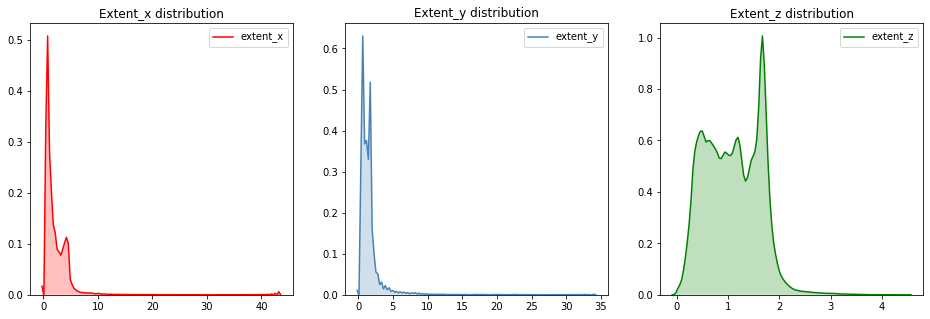

In [17]:
sns.axes_style("white")

fig, ax = plt.subplots(1,3,figsize=(16,5))

plt.subplot(1,3,1)
sns.kdeplot(agents['extent_x'], shade=True, color='red');
plt.title("Extent_x distribution")

plt.subplot(1,3,2)
sns.kdeplot(agents['extent_y'], shade=True, color='steelblue');
plt.title("Extent_y distribution")

plt.subplot(1,3,3)
sns.kdeplot(agents['extent_z'], shade=True, color='green');
plt.title("Extent_z distribution")

plt.show();

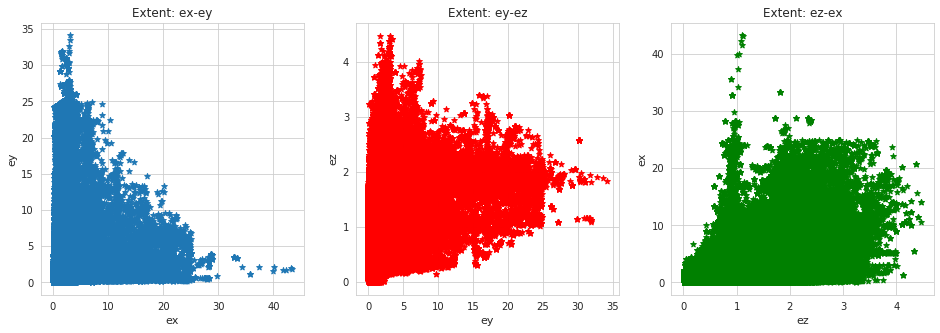

In [18]:
sns.set_style('whitegrid')

fig, ax = plt.subplots(1,3,figsize=(16,5))
plt.subplot(1,3,1)
plt.scatter(agents['extent_x'], agents['extent_y'], marker='*')
plt.xlabel('ex', fontsize=11); plt.ylabel('ey', fontsize=11)
plt.title("Extent: ex-ey")

plt.subplot(1,3,2)
plt.scatter(agents['extent_y'], agents['extent_z'], marker='*', color="red")
plt.xlabel('ey', fontsize=11); plt.ylabel('ez', fontsize=11)
plt.title("Extent: ey-ez")

plt.subplot(1,3,3)
plt.scatter(agents['extent_z'], agents['extent_x'], marker='*', color="green")
plt.xlabel('ez', fontsize=11); plt.ylabel('ex', fontsize=11)
plt.title("Extent: ez-ex")

plt.show();

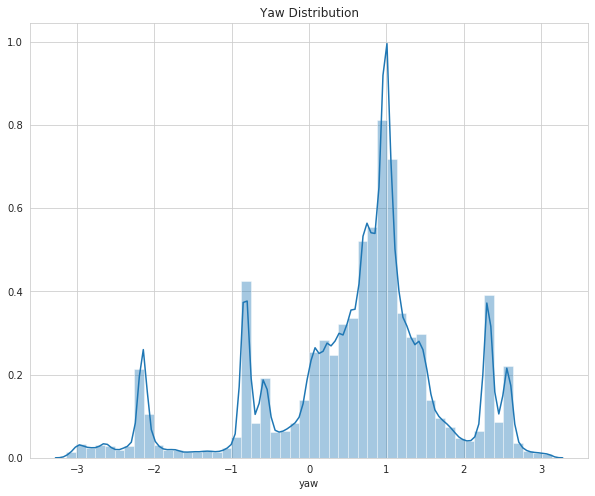

In [36]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
sns.distplot(agents['yaw'])
plt.title("Yaw Distribution")
plt.show()

In [19]:
agents['velocity_x'] = np.array(agents['velocity'].to_list())[:,0]
agents['velocity_y'] = np.array(agents['velocity'].to_list())[:,1]
agents_vel = agents.drop('velocity', axis=1)
agents_v = agents_vel[["centroid_x", "centroid_y", 'extent_x', 'extent_y', 'extent_z', "yaw", "velocity_x", "velocity_y", "track_id", "label_probabilities"]]
del agents
agents_v

,centroid_x,centroid_y,extent_x,extent_y,extent_z,yaw,velocity_x,velocity_y,track_id,label_probabilities
0,665.034241,-2207.512207,4.391328,1.813830,1.590976,1.016675,0.000000,0.000000,1,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,717.661255,-2173.760010,5.150925,1.953092,2.040210,-0.783224,0.000000,0.000000,2,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,730.681396,-2180.678955,2.948282,1.484217,1.112507,-0.321747,0.000000,0.000000,3,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,671.253601,-2204.745361,1.706702,0.928787,0.628216,0.785501,0.000000,0.000000,4,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,669.776306,-2213.004639,0.251099,0.634378,1.654377,1.492359,0.000000,0.000000,5,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...
1893731,278.237427,50.953831,2.651326,16.242971,1.845905,0.728024,0.000000,0.000000,1478,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1893732,321.081635,35.298061,0.345643,0.755924,0.586375,0.582523,0.096600,-0.233407,1479,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1893733,227.163437,73.988060,2.024245,0.354411,0.843570,0.942606,-0.091657,3.918654,1481,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1893734,213.863144,75.332466,0.512778,1.280945,1.133428,-0.809572,0.000000,0.000000,1483,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


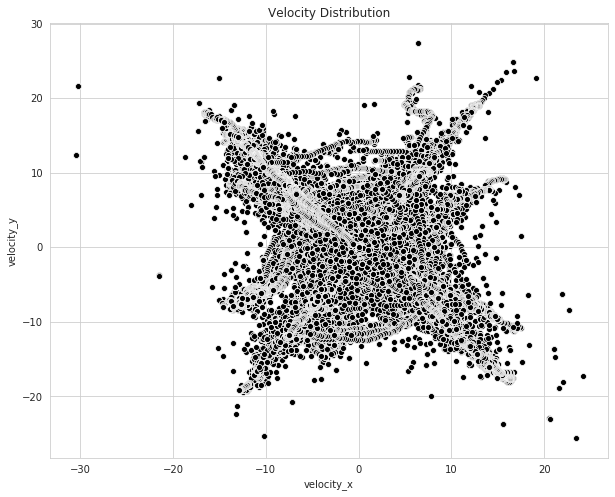

In [20]:
fig, ax = plt.subplots(1,1,figsize=(10,8))

with sns.axes_style("whitegrid"):
    sns.scatterplot(x=agents_v["velocity_x"], y=agents_v["velocity_y"], color='k');
    plt.title('Velocity Distribution')

In [76]:
np.unique(agents['track_id']).shape

(2547,)

In [21]:
agents = zarr_dataset.agents
probabilities = agents["label_probabilities"]
labels_indexes = np.argmax(probabilities, axis=1)
counts = []
for idx_label, label in enumerate(PERCEPTION_LABELS):
    counts.append(np.sum(labels_indexes == idx_label))
    
table = PrettyTable(field_names=["label", "counts"])
for count, label in zip(counts, PERCEPTION_LABELS):
    table.add_row([label, count])
print(table)

+------------------------------------+---------+
|               label                |  counts |
+------------------------------------+---------+
|      PERCEPTION_LABEL_NOT_SET      |    0    |
|      PERCEPTION_LABEL_UNKNOWN      | 1324481 |
|     PERCEPTION_LABEL_DONTCARE      |    0    |
|        PERCEPTION_LABEL_CAR        |  519385 |
|        PERCEPTION_LABEL_VAN        |    0    |
|       PERCEPTION_LABEL_TRAM        |    0    |
|        PERCEPTION_LABEL_BUS        |    0    |
|       PERCEPTION_LABEL_TRUCK       |    0    |
| PERCEPTION_LABEL_EMERGENCY_VEHICLE |    0    |
|   PERCEPTION_LABEL_OTHER_VEHICLE   |    0    |
|      PERCEPTION_LABEL_BICYCLE      |    0    |
|    PERCEPTION_LABEL_MOTORCYCLE     |    0    |
|      PERCEPTION_LABEL_CYCLIST      |   6688  |
|   PERCEPTION_LABEL_MOTORCYCLIST    |    0    |
|    PERCEPTION_LABEL_PEDESTRIAN     |  43182  |
|      PERCEPTION_LABEL_ANIMAL       |    0    |
|     AVRESEARCH_LABEL_DONTCARE      |    0    |
+-------------------

In [22]:
from colorama import Fore, Back, Style

In [23]:
print(f'{Fore.YELLOW}Total number of agents in sample .zarr files is {Style.RESET_ALL}{len(zarr_dataset.agents)}. {Fore.BLUE}\nAfter summing up the elements in count column we can see we have {Style.RESET_ALL}{(1324481 + 519385 + 6688 + 43182)} {Fore.BLUE}agents in total.')

Total number of agents in sample .zarr files is 1893736. 
After summing up the elements in count column we can see we have 1893736 agents in total.


In [24]:
scenes = pd.DataFrame.from_records(zarr_dataset.scenes, columns = ['frame_index_interval', 'host', 'start_time', 'end_time'])
scenes.head()

,frame_index_interval,host,start_time,end_time
0,"[0, 248]",host-a013,1572643684617362176,1572643709617362176
1,"[248, 497]",host-a013,1572643749559148288,1572643774559148288
2,"[497, 746]",host-a013,1572643774559148288,1572643799559148288
3,"[746, 995]",host-a013,1572643799559148288,1572643824559148288
4,"[995, 1244]",host-a013,1572643824559148288,1572643849559148288


In [25]:
scenes['frame_start_index'] = np.array(scenes['frame_index_interval'].to_list())[:,0]
scenes['frame_end_index'] = np.array(scenes['frame_index_interval'].to_list())[:,1]
scenes_new = scenes.drop('frame_index_interval', axis=1)
scenes_new = scenes_new[["frame_start_index", "frame_end_index", 'host', 'start_time', 'end_time']]
del scenes
scenes_new.head()

,frame_start_index,frame_end_index,host,start_time,end_time
0,0,248,host-a013,1572643684617362176,1572643709617362176
1,248,497,host-a013,1572643749559148288,1572643774559148288
2,497,746,host-a013,1572643774559148288,1572643799559148288
3,746,995,host-a013,1572643799559148288,1572643824559148288
4,995,1244,host-a013,1572643824559148288,1572643849559148288


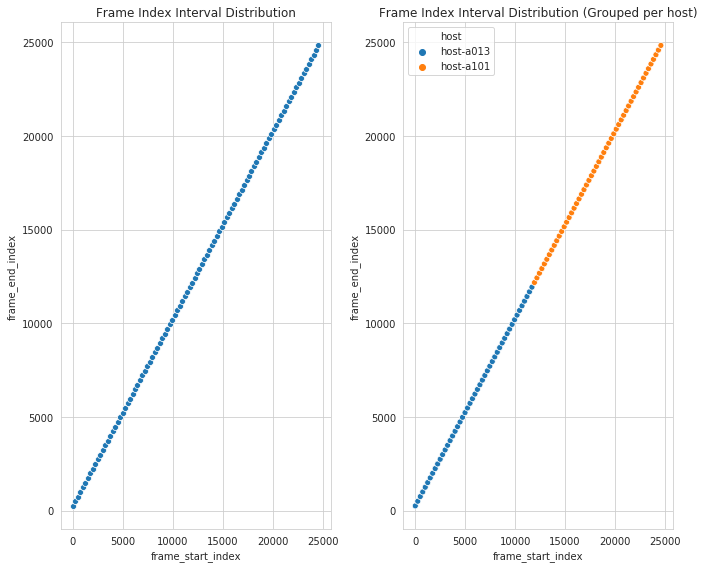

In [26]:
f = plt.figure(figsize=(10, 8))
gs = f.add_gridspec(1, 2)

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0,0])
    sns.scatterplot(scenes_new['frame_start_index'], scenes_new['frame_end_index'])
    plt.title('Frame Index Interval Distribution')
    
with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0,1])
    sns.scatterplot(scenes_new['frame_start_index'], scenes_new['frame_end_index'], hue=scenes_new['host'])
    plt.title('Frame Index Interval Distribution (Grouped per host)')
    
f.tight_layout()

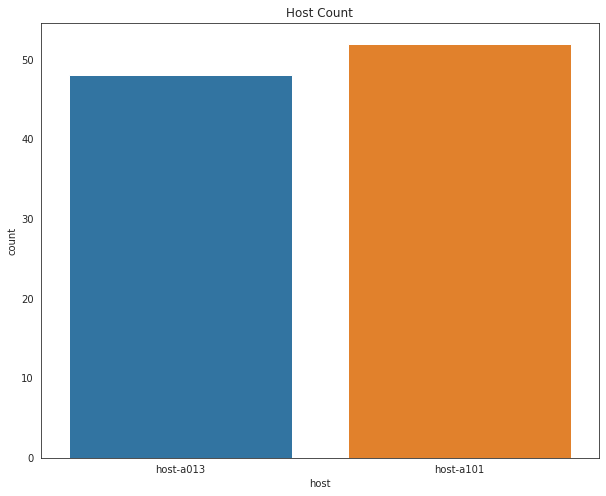

In [27]:
f = plt.figure(figsize=(10, 8))

with sns.axes_style("white"):
    sns.countplot(scenes_new['host']);
    plt.title("Host Count")

In [28]:
frames = pd.DataFrame.from_records(zarr_dataset.frames, columns = ['timestamp', 'agent_index_interval', 'traffic_light_faces_index_interval', 'ego_translation','ego_rotation'])
frames.head()

,timestamp,agent_index_interval,traffic_light_faces_index_interval,ego_translation,ego_rotation
0,1572643684801892606,"[0, 38]","[0, 0]","[680.6197509765625, -2183.32763671875, 288.541...","[[0.5467331409454346, -0.837294340133667, 0.00..."
1,1572643684901714926,"[38, 85]","[0, 0]","[681.1856079101562, -2182.42236328125, 288.608...","[[0.5470812916755676, -0.837059736251831, 0.00..."
2,1572643685001499246,"[85, 142]","[0, 0]","[681.7647094726562, -2181.522705078125, 288.68...","[[0.5479603409767151, -0.8364874720573425, 0.0..."
3,1572643685101394026,"[142, 200]","[0, 0]","[682.3414306640625, -2180.624267578125, 288.75...","[[0.5491225123405457, -0.8357341885566711, 0.0..."
4,1572643685201412346,"[200, 254]","[0, 0]","[682.9197998046875, -2179.73046875, 288.827392...","[[0.5504215955734253, -0.8348868489265442, -7...."


In [29]:
frames['ego_translation_x'] = np.array(frames['ego_translation'].to_list())[:,0]
frames['ego_translation_y'] = np.array(frames['ego_translation'].to_list())[:,1]
frames['ego_translation_z'] = np.array(frames['ego_translation'].to_list())[:,2]
frames_new = frames.drop('ego_translation', axis=1)
frames_new = frames_new[['timestamp', 'agent_index_interval', 'traffic_light_faces_index_interval',
                         'ego_translation_x', 'ego_translation_y', 'ego_translation_z', 'ego_rotation']]
del frames
frames_new.head()

,timestamp,agent_index_interval,traffic_light_faces_index_interval,ego_translation_x,ego_translation_y,ego_translation_z,ego_rotation
0,1572643684801892606,"[0, 38]","[0, 0]",680.619751,-2183.327637,288.541138,"[[0.5467331409454346, -0.837294340133667, 0.00..."
1,1572643684901714926,"[38, 85]","[0, 0]",681.185608,-2182.422363,288.608124,"[[0.5470812916755676, -0.837059736251831, 0.00..."
2,1572643685001499246,"[85, 142]","[0, 0]",681.764709,-2181.522705,288.680939,"[[0.5479603409767151, -0.8364874720573425, 0.0..."
3,1572643685101394026,"[142, 200]","[0, 0]",682.341431,-2180.624268,288.755920,"[[0.5491225123405457, -0.8357341885566711, 0.0..."
4,1572643685201412346,"[200, 254]","[0, 0]",682.919800,-2179.730469,288.827393,"[[0.5504215955734253, -0.8348868489265442, -7...."


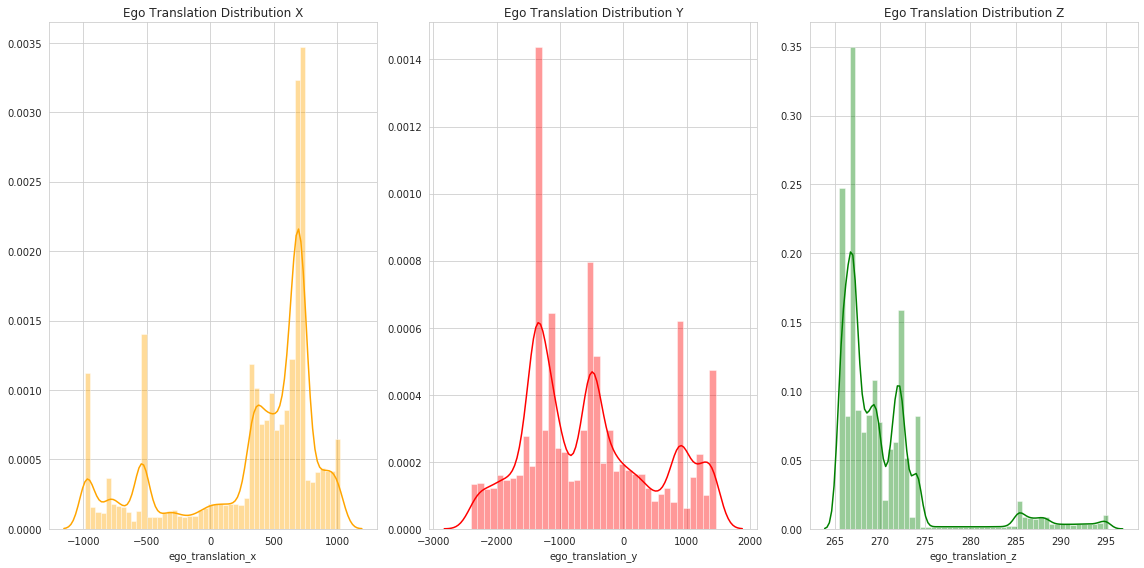

In [30]:
f = plt.figure(figsize=(16, 8))
gs = f.add_gridspec(1, 3)

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0,0])
    sns.distplot(frames_new['ego_translation_x'], color='Orange')
    plt.title('Ego Translation Distribution X')
    
with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0,1])
    sns.distplot(frames_new['ego_translation_y'], color='Red')
    plt.title('Ego Translation Distribution Y')
    
with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0,2])
    sns.distplot(frames_new['ego_translation_z'], color='Green')
    plt.title('Ego Translation Distribution Z')
    
f.tight_layout()

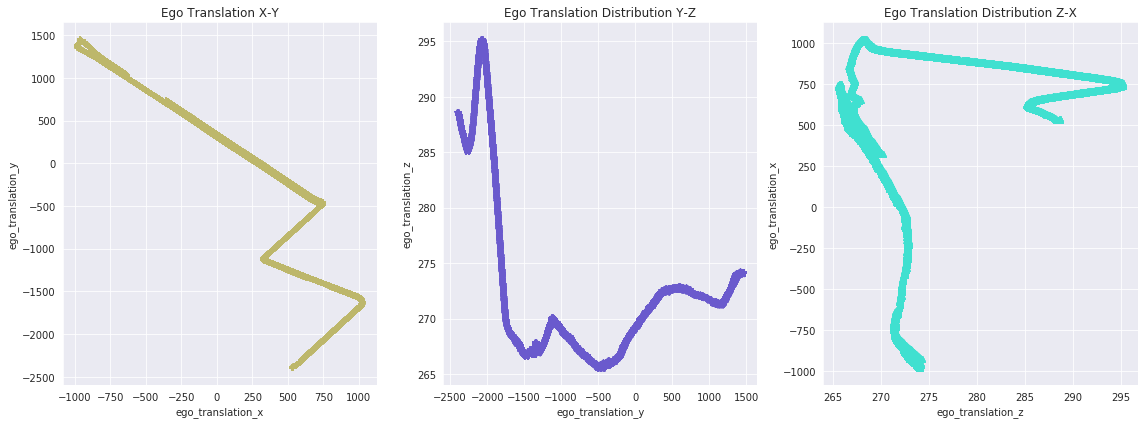

In [31]:
f = plt.figure(figsize=(16, 6))
gs = f.add_gridspec(1, 3)

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0,0])
    plt.scatter(frames_new['ego_translation_x'], frames_new['ego_translation_y'],
                    color='darkkhaki', marker='+')
    plt.title('Ego Translation X-Y')
    plt.xlabel('ego_translation_x')
    plt.ylabel('ego_translation_y')
    
with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0,1])
    plt.scatter(frames_new['ego_translation_y'], frames_new['ego_translation_z'],
                    color='slateblue', marker='*')
    plt.title('Ego Translation Distribution Y-Z')
    plt.xlabel('ego_translation_y')
    plt.ylabel('ego_translation_z')
    
with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0,2])
    plt.scatter(frames_new['ego_translation_z'], frames_new['ego_translation_x'],
                    color='turquoise', marker='^')
    plt.title('Ego Translation Distribution Z-X')
    plt.xlabel('ego_translation_z')
    plt.ylabel('ego_translation_x')
    
f.tight_layout()

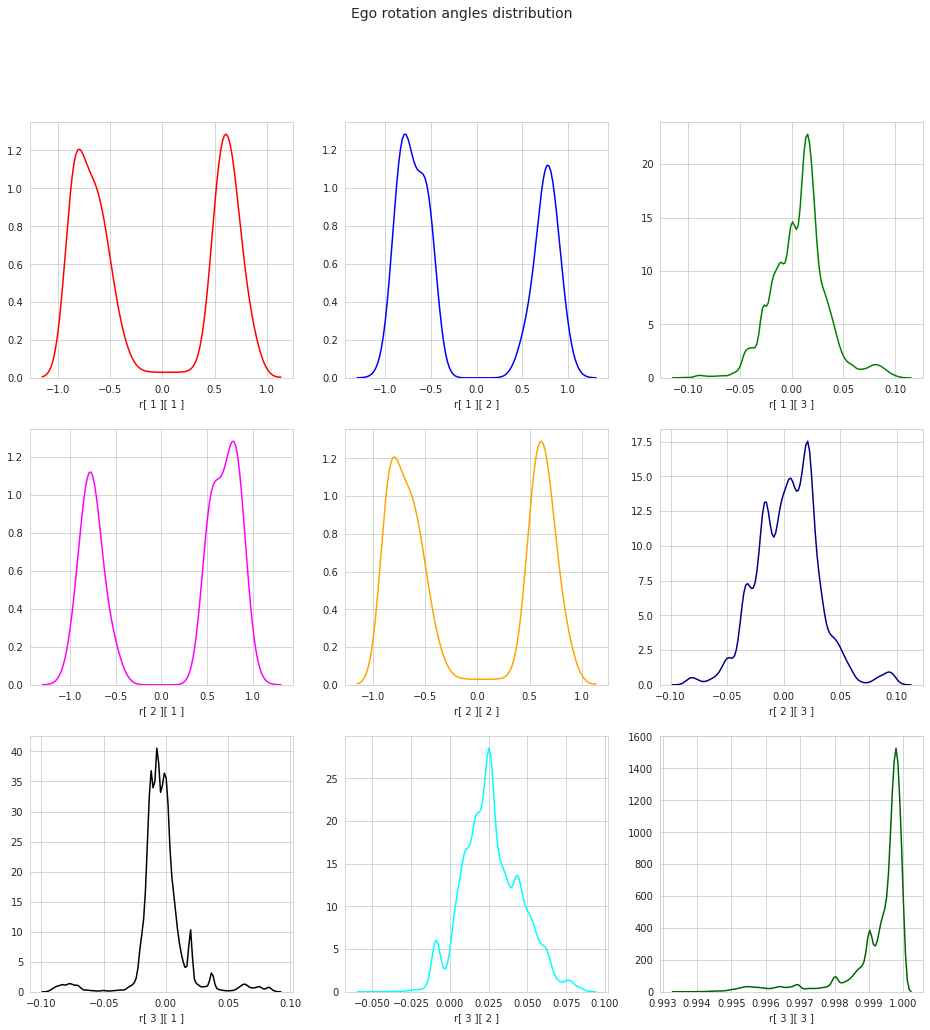

In [32]:
fig, ax = plt.subplots(3,3,figsize=(16,16))
colors = ['red', 'blue', 'green', 'magenta', 'orange', 'darkblue', 'black', 'cyan', 'darkgreen']
for i in range(0,3):
    for j in range(0,3):
        df = frames_new['ego_rotation'].apply(lambda x: x[i][j])
        plt.subplot(3,3,i * 3 + j + 1)
        sns.distplot(df, hist=False, color = colors[ i * 3 + j  ])
        plt.xlabel(f'r[ {i + 1} ][ {j + 1} ]')
fig.suptitle("Ego rotation angles distribution", size=14)
plt.show()

In [33]:
traffic_light_faces = pd.DataFrame.from_records(zarr_dataset.tl_faces, columns = ['face_id', 'traffic_light_id', 'traffic_light_face_status'])
traffic_light_faces.head()

,face_id,traffic_light_id,traffic_light_face_status
0,xbVG,/ggb,"[0.0, 0.0, 1.0]"
1,jutE,/ggb,"[0.0, 0.0, 1.0]"
2,CDDo,/ggb,"[0.0, 0.0, 1.0]"
3,xbVG,/ggb,"[0.0, 0.0, 1.0]"
4,jutE,/ggb,"[0.0, 0.0, 1.0]"


In [34]:
agents_v.head()

,centroid_x,centroid_y,extent_x,extent_y,extent_z,yaw,velocity_x,velocity_y,track_id,label_probabilities
0,665.034241,-2207.512207,4.391328,1.813830,1.590976,1.016675,0.0,0.0,1,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,717.661255,-2173.760010,5.150925,1.953092,2.040210,-0.783224,0.0,0.0,2,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,730.681396,-2180.678955,2.948282,1.484217,1.112507,-0.321747,0.0,0.0,3,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,671.253601,-2204.745361,1.706702,0.928787,0.628216,0.785501,0.0,0.0,4,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,669.776306,-2213.004639,0.251099,0.634378,1.654377,1.492359,0.0,0.0,5,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [83]:
scenes['end_time'][0]-scenes['start_time'][0]

25000000000

In [53]:
vel = np.stack([agents_v['velocity_x'],agents_v['velocity_y']])

In [63]:
vel[:,:1000].T.shape

(1000, 2)

In [65]:
np.dot(vel[:,:1000], vel[:,:1000].T)

array([[242.02303, 357.56195],
       [357.56195, 633.02014]], dtype=float32)

In [51]:
agents_v['velocity_y']

0          0.000000
1          0.000000
2          0.000000
3          0.000000
4          0.000000
             ...   
1893731    0.000000
1893732   -0.233407
1893733    3.918654
1893734    0.000000
1893735    0.000000
Name: velocity_y, Length: 1893736, dtype: float32

In [9]:
from tqdm import tqdm

frames = zarr_dataset.frames
coords = np.zeros((len(frames), 2))
for idx_coord, idx_data in enumerate(tqdm(range(len(frames)), desc="getting centroid to plot trajectory")):
    frame = zarr_dataset.frames[idx_data]
    coords[idx_coord] = frame["ego_translation"][:2]

getting centroid to plot trajectory: 100%|██████████| 24838/24838 [00:24<00:00, 1004.88it/s]


(-2500, 1600)

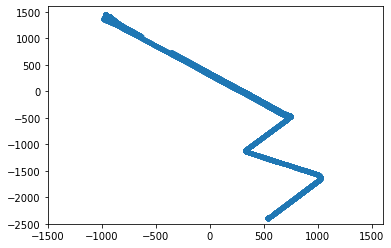

In [10]:
plt.scatter(coords[:, 0], coords[:, 1], marker='.')
axes = plt.gca()
axes.set_xlim([-1500, 1600])
axes.set_ylim([-2500, 1600])